In [71]:
%pylab inline
# %load_ext memory_profiler

import os
import time
import warnings

from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import networkx
import numpy as np
import pandas as pd
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianModel
import pygraphviz
from pomegranate import BayesianNetwork, NormalDistribution
from pomegranate.utils import plot_networkx
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, ward_tree
from sklearn.metrics import plot_confusion_matrix, accuracy_score, mean_squared_error, precision_score, f1_score, recall_score
from sklearn.naive_bayes import GaussianNB
import yfinance as yf

os.chdir('../')
from src.features.build_features import (
    daily_return, uniform_clustering, create_shifted_rt, downloading_stocks_data, return_in_period, binary_clustering)
from src.models.k2 import k2, graph_from_dict
os.chdir('./notebooks')

RANDOM_SEED = 42

random.seed(RANDOM_SEED)
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


# Aquisição dos dados

Segundo o artigo, eles usaram dados do índice iBobespa (**^IBOV**), entre 01/01/2020 e 01/07/2021.

In [2]:
start_date = "2011-01-01"
end_date = "2021-05-31"

df_ibovespa = yf.download('^BVSP', start=start_date, end=end_date)

# df_ibovespa = yf.download("^N225", start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


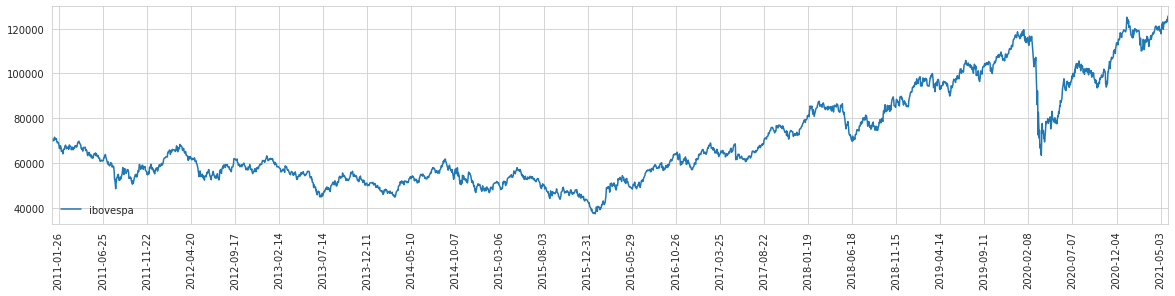

In [3]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)

ax.plot(df_ibovespa['Close'], label="ibovespa")

date_min = df_ibovespa.index.min()
date_max = df_ibovespa.index.max()
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='lower left', frameon=False)
plt.xticks(rotation=90)
plt.show();

### IMPORTANTE!

Continuar somente com o Índice Nikkey 225, por enquanto. Pois não temos somente os dados da Toyota a partir de 1999.


## Preparação dos dados

Nesta seção, tomaremos as seguintes ações:

1. Separação do conjunto de dados de treinamento (22/02/1985 até 30/11/2008) e de validação do modelo (01/12/2008 até 30/12/2008).
1. Criação do atributo **"p/e"**: $ p/e = 100*(ln({r_{t}}) - ln({r_{t-1}})) $.
1. Criação da resposta **cluster** usando apenas a simples separação. Lembrando que no artigo, os autores compararam duas abordagens diferentes para discretizar a resposta ((a) simples separação e (b) Ward).

In [4]:
df = df_ibovespa[["Close"]].copy()
df = daily_return(df)
df = create_shifted_rt(df, np.arange(1,21,2))
# df = uniform_clustering(df)
df = binary_clustering(df)
# df = df[[column for column in df.columns if 'cluster_' in column]].copy()
df.dropna(how='any', axis=0, inplace=True)

df.head()

,Close,rt-1,rt-3,rt-5,rt-7,rt-9,rt-11,rt-13,rt-15,rt-17,...,cluster_rt-1,cluster_rt-3,cluster_rt-5,cluster_rt-7,cluster_rt-9,cluster_rt-11,cluster_rt-13,cluster_rt-15,cluster_rt-17,cluster_rt-19
Date,,,,,,,,,,,,,,,,,,,,,
2011-02-01,1.892604,-0.184584,-0.962277,0.424366,-0.710503,0.439487,0.309189,1.703595,0.099869,-0.722810,...,0,0,1,0,1,1,1,1,0,1
2011-02-02,-1.723014,1.892604,-2.008246,-1.039565,-0.618626,-1.222901,-0.467683,-1.281330,0.421203,-0.742345,...,1,0,0,0,0,0,0,1,0,1
2011-02-03,0.115396,-1.723014,-0.184584,-0.962277,0.424366,-0.710503,0.439487,0.309189,1.703595,0.099869,...,0,0,0,1,0,1,1,1,1,0
2011-02-04,-2.266180,0.115396,1.892604,-2.008246,-1.039565,-0.618626,-1.222901,-0.467683,-1.281330,0.421203,...,1,1,0,0,0,0,0,0,1,0
2011-02-07,0.142386,-2.266180,-1.723014,-0.184584,-0.962277,0.424366,-0.710503,0.439487,0.309189,1.703595,...,0,0,0,0,1,0,1,1,1,1


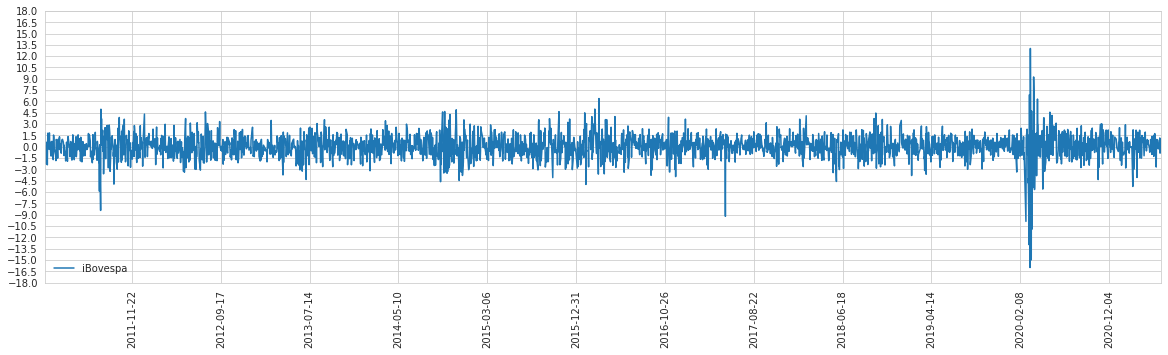

In [26]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

date_min = df.index.min()
date_max = df.index.max()

ax.plot(df['Close'], label="iBovespa")

ax.xaxis.set_major_locator(plt.MaxNLocator(13))
ax.yaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_ylim(-18, 18)
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='lower left', frameon=False)
plt.xticks(rotation=90)
plt.show();

## Achando a estrutura da rede

In [27]:
lst_cluster = [column for column in df.columns if 'cluster_' in column]

df_clustered = df[lst_cluster].copy()

df_clustered = df_clustered[df_clustered.columns[::-1]]

df_clustered.head()

,cluster_rt-19,cluster_rt-17,cluster_rt-15,cluster_rt-13,cluster_rt-11,cluster_rt-9,cluster_rt-7,cluster_rt-5,cluster_rt-3,cluster_rt-1,cluster_Close
Date,,,,,,,,,,,
2011-02-01,1,0,1,1,1,1,0,1,0,0,1
2011-02-02,1,0,1,0,0,0,0,0,0,1,0
2011-02-03,0,1,1,1,1,0,1,0,0,0,1
2011-02-04,0,1,0,0,0,0,0,0,1,1,0
2011-02-07,1,1,1,1,0,1,0,0,0,0,1


In [28]:
# a = networkx.DiGraph()
# b = lst_cluster.copy()
# b.remove('cluster_Close')
# edges = []

# for item in b:
#     a.add_edge(tuple([df_clustered.columns.get_loc(item)]), tuple([df_clustered.columns.get_loc('cluster_Close')]))
#     edges.append(tuple([item, df_clustered.columns.get_loc('cluster_Close')]))

# print(edges)
# print("Constraint Graph")
# plt.figure(figsize=(10, 8))
# plot_networkx(a)
# plt.show()

Constraint Graph


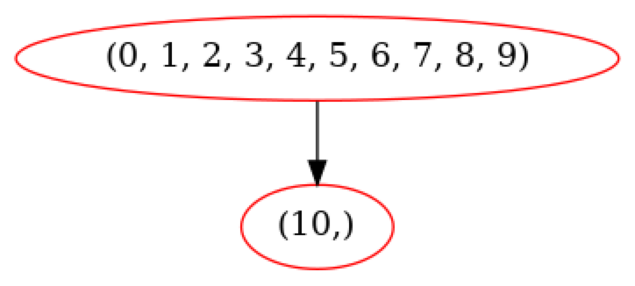

In [29]:
a = networkx.DiGraph()
lst_cluster = [column for column in df_clustered.columns if 'cluster_' in column]
b = lst_cluster.copy()
b.remove('cluster_Close')

lst = [column for column in df_clustered.columns if 'cluster_Close' not in column]
lst = [df_clustered.columns.get_loc(x) for x in lst]

a.add_edge(tuple(lst), tuple([df_clustered.columns.get_loc('cluster_Close')]))

print("Constraint Graph")
plt.figure(figsize=(20, 5))
plot_networkx(a)
plt.show()

In [30]:
# a = networkx.DiGraph()
# lst_cluster = [column for column in df_clustered.columns if 'cluster_' in column]
# b = lst_cluster.copy()
# b.remove('cluster_Close')

# for i in np.arange(len(df_clustered.columns)-1):
#     a.add_edge(tuple([df_clustered.columns.get_loc(lst_inverted[i])]), tuple([df_clustered.columns.get_loc(lst_inverted[i])+1]))

# print("Constraint Graph")
# plt.figure(figsize=(20, 5))
# plot_networkx(a)
# plt.show()

In [32]:
ntest = 20

Finding Elimination Order: : : 0it [06:21, ?it/s]
Finding Elimination Order: : : 0it [05:21, ?it/s]
Finding Elimination Order: : : 0it [00:55, ?it/s]
Finding Elimination Order: : : 0it [00:55, ?it/s]
Finding Elimination Order: : : 0it [00:54, ?it/s]
Finding Elimination Order: : : 0it [00:54, ?it/s]

5 ((), (), (), (), (), (), (), (), (), (), (1, 5))
9 ((), (), (), (), (), (), (), (), (), (), (1, 5))
11 ((), (), (), (), (), (), (), (), (), (), (2, 4))


13 ((), (), (), (), (), (), (), (), (), (), (2, 4))
15 ((), (), (), (), (), (), (), (), (), (), (2, 4))
17 ((), (), (), (), (), (), (), (), (), (), (2, 4))
19 ((), (), (), (), (), (), (), (), (), (), (2, 4))
21 ((), (), (), (), (), (), (), (), (), (), (2, 4))
23 ((), (), (), (), (), (), (), (), (), (), (2, 4))
25 ((), (), (), (), (), (), (), (), (), (), (2, 4))
27 ((), (), (), (), (), (), (), (), (), (), (2, 4))
29 ((), (), (), (), (), (), (), (), (), (), (2, 4))
31 ((), (), (), (), (), (), (), (), (), (), (2, 4))
33 ((), (), (), (), (), (), (), (), (), (), (2, 4))
37 ((), (), (), (), (), (), (), (), (), (), (5, 9))
39 ((), (), (), (), (), (), (), (), (), (), (5, 9))
41 ((), (), (), (), (), (), (), (), (), (), (5, 9))
43 ((), (), (), (), (), (), (), (), (), (), (5, 9))
45 ((), (), (), (), (), (), (), (), (), (), (5, 9))
55 ((), (), (), (), (), (), (), (), (), (), (2, 5))
57 ((), (), (), (), (), (), (), (), (), (), (2, 5))


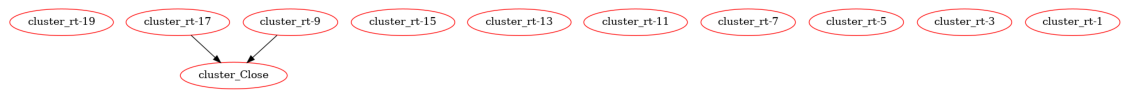

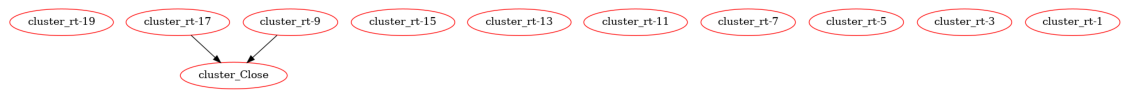

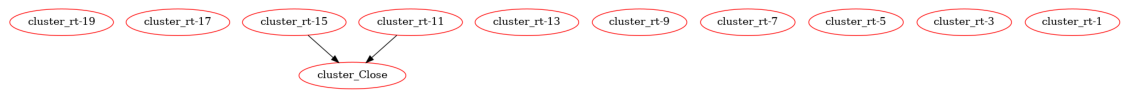

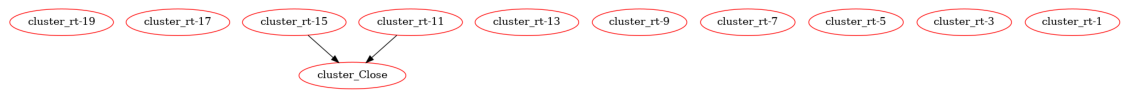

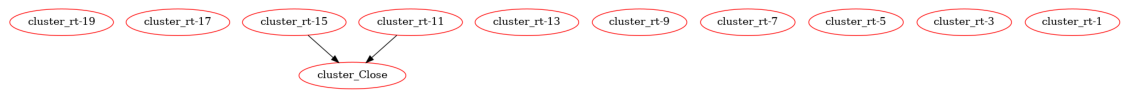

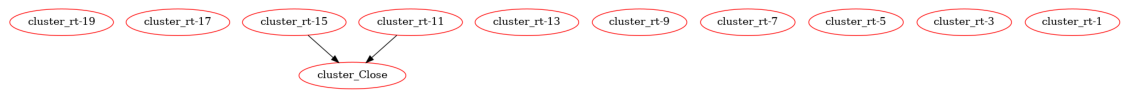

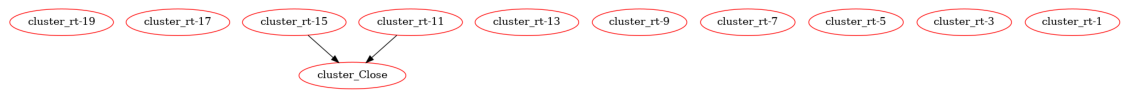

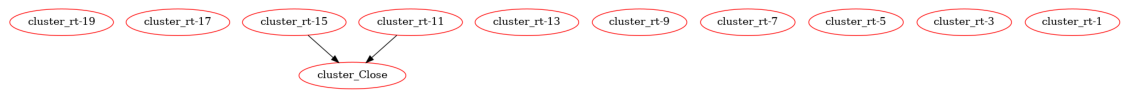

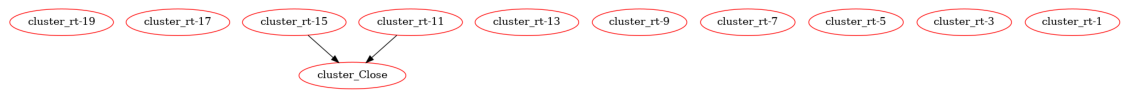

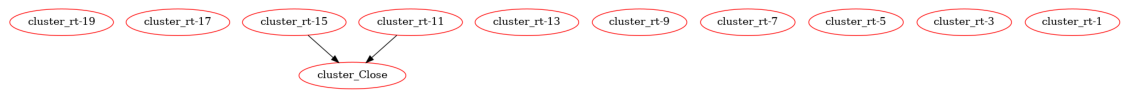

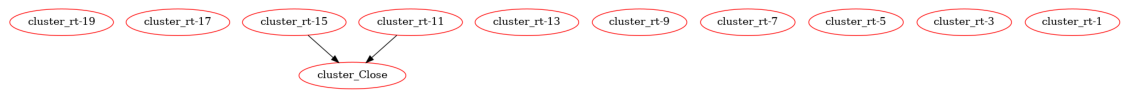

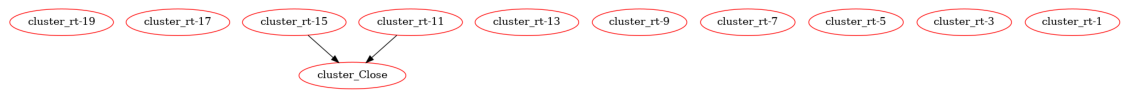

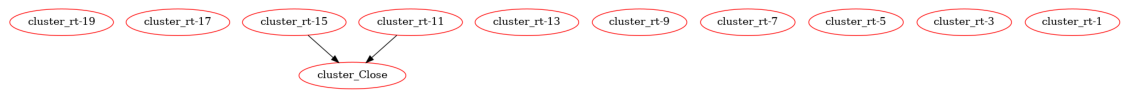

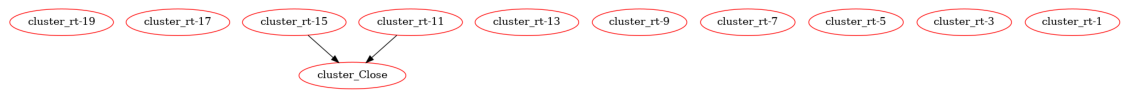

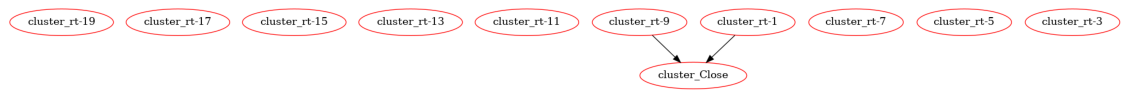

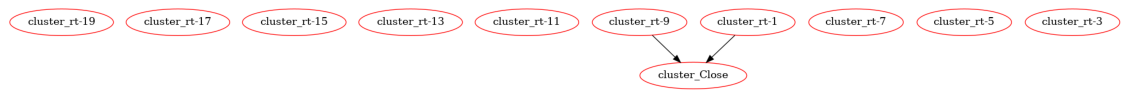

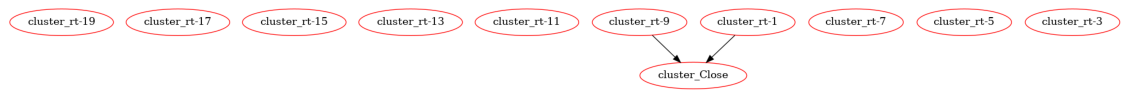

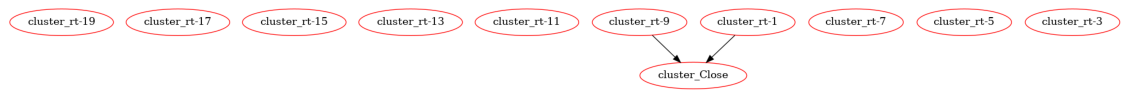

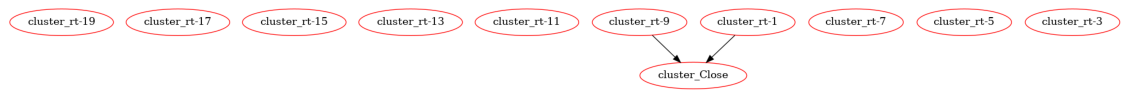

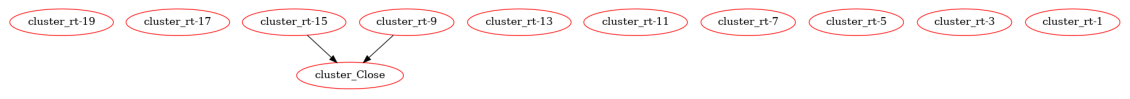

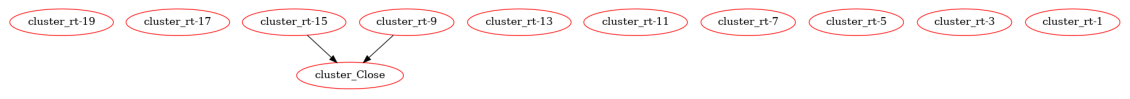

In [113]:
for days_before in np.arange(5, 100, 2):
    model = BayesianNetwork.from_samples(
        df_clustered[-days_before-ntest:-ntest], algorithm='exact', state_names=lst_cluster, reduce_dataset=False, n_jobs=-1,
        constraint_graph=a
    )
    if len(model.structure[-1]) > 1:
        print(days_before, model.structure)
        plt.figure(figsize=(20, 5))
        model.plot()

## Aplicando a mesma lógica aplicada no notebook do ARIMA

In [34]:
%%time

ntotal = df.shape[0]
X_pred = []
X_real = df_clustered[-ntest:]
metrics = {}

for cont in np.arange(10, 300, 1):
    X_train = df_clustered[-ntest-cont:-ntest].copy()
    X_test = df_clustered[-ntest:].copy()
    X_test.iloc[:, -1] = None

    model = BayesianNetwork.from_samples(
        X_train, algorithm='exact', state_names=lst_cluster
        , constraint_graph=a
        , reduce_dataset=False, n_jobs=-1)
    
    X_pred = model.predict(X_test.to_numpy())
    
    if len(model.structure[-1]) > 1:
#         plt.figure(figsize=(20, 5))
#         model.plot()
        
        y_pred = []
        for item in X_pred:
            y_pred.append(item[-1])
        
        y_real = X_real.iloc[:,-1].values.tolist()
        
        metrics[cont] = {
            'structure length': model.structure[-1]
            , 'structure': len(model.structure[-1])
            , 'accuracy_score': accuracy_score(y_real, y_pred)
            , 'precision_score': precision_score(y_real, y_pred)
            , 'recall': recall_score(y_real, y_pred)
            , 'f1_score': f1_score(y_real, y_pred)}
        
#         print(f"""
#         DAYS QTY USED FOR TRAINING: {cont}
#         {model.structure}

#         y_real: {y_real}
#         y_pred: {y_pred}
#         accuracy_score: {round(accuracy_score(y_real, y_pred),2)}
#         precision_score: {round(precision_score(y_real, y_pred),2)}
#         recall_score: {round(recall_score(y_real, y_pred),2)}
#         f1_score: {round(f1_score(y_real, y_pred),2)} 
#         """)
        
# X_train: {X_train.shape}
# X_test: {X_test.shape}
# X_pred: ({len(X_pred)}, {len(X_pred[0])})
# y_pred: {len(y_pred)}
# y_real: {len(y_real)}


CPU times: user 6.62 s, sys: 871 ms, total: 7.49 s
Wall time: 6.86 s


In [35]:
df_metrics = pd.DataFrame.from_dict(metrics, orient='index')
df_metrics.sort_values(by="f1_score", ascending=False).head()
# df_metrics

,structure length,structure,accuracy_score,precision_score,recall,f1_score
15,"(0, 2)",2,0.55,0.692308,0.642857,0.666667
17,"(0, 2)",2,0.55,0.692308,0.642857,0.666667
18,"(0, 2)",2,0.55,0.692308,0.642857,0.666667
19,"(0, 2)",2,0.55,0.692308,0.642857,0.666667
16,"(0, 2)",2,0.55,0.692308,0.642857,0.666667


<Figure size 1440x360 with 0 Axes>

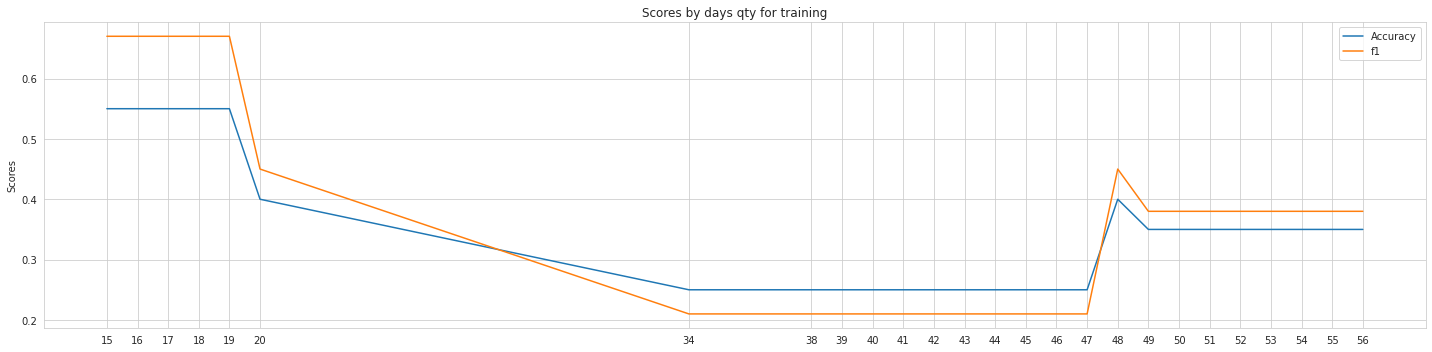

In [36]:
plt.figure(figsize(20,5))

labels = df_metrics.index.tolist()
plt_accuracy_score = round(df_metrics['accuracy_score'], 2)
plt_f1_score = round(df_metrics['f1_score'],2)

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, plt_accuracy_score, width, label='Accuracy')
# rects2 = ax.bar(x + width/2, plt_f1_score, width, label='f1')
rects1 = ax.plot(labels, plt_accuracy_score, label='Accuracy')
rects2 = ax.plot(labels, plt_f1_score, label='f1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by days qty for training')
ax.set_xticks(labels)
# ax.set_xticklabels(labels)
ax.legend()

# ax.bar_label(rects1, padding=1)
# ax.bar_label(rects2, padding=1)

fig.tight_layout()

plt.show();

In [58]:
ntest = 20
horizonte = 18
ntotal = df.shape[0]
X_predict = []
X_real = df_clustered[-ntest:]

for cont in np.arange(ntest):
    X_train = df_clustered[-ntest+cont-horizonte:-ntest+cont].copy()
    X_test = df_clustered[-ntest+cont:ntotal-ntest+1+cont].copy()
#     X_test.iloc[:, -1] = None

    model = BayesianNetwork.from_samples(
        X_train, algorithm='exact', state_names=lst_cluster, constraint_graph=a, reduce_dataset=False, n_jobs=-1
    )
    
    print(model.structure)
    print(f"""X_train: {X_train.index[-1]}, X_test: {X_test.index[-1]}""")
    X_predict.append(model.predict(X_test.to_numpy()))
#     print(model.predict_proba(X_test.to_numpy()))

Finding Elimination Order: : : 0it [00:37, ?it/s]
Finding Elimination Order: : : 0it [00:37, ?it/s]
Finding Elimination Order: : : 0it [00:37, ?it/s]
Finding Elimination Order: : : 0it [00:37, ?it/s]
Finding Elimination Order: : : 0it [00:37, ?it/s]

((), (), (), (), (), (), (), (), (), (), (0, 2))
X_train: 2021-04-30 00:00:00, X_test: 2021-05-03 00:00:00
((), (), (), (), (), (), (), (), (), (), (0, 2))
X_train: 2021-05-03 00:00:00, X_test: 2021-05-04 00:00:00
((), (), (), (), (), (), (), (), (), (), (0, 2))
X_train: 2021-05-04 00:00:00, X_test: 2021-05-05 00:00:00
((), (), (), (), (), (), (), (), (), (), (0, 2))
X_train: 2021-05-05 00:00:00, X_test: 2021-05-06 00:00:00
((), (), (), (), (), (), (), (), (), (), (0, 2))
X_train: 2021-05-06 00:00:00, X_test: 2021-05-07 00:00:00
((), (), (), (), (), (), (), (), (), (), (2,))
X_train: 2021-05-07 00:00:00, X_test: 2021-05-10 00:00:00
((), (), (), (), (), (), (), (), (), (), (2,))
X_train: 2021-05-10 00:00:00, X_test: 2021-05-11 00:00:00
((), (), (), (), (), (), (), (), (), (), (2,))
X_train: 2021-05-11 00:00:00, X_test: 2021-05-12 00:00:00
((), (), (), (), (), (), (), (), (), (), (2, 4))
X_train: 2021-05-12 00:00:00, X_test: 2021-05-13 00:00:00
((), (), (), (), (), (), (), (), (), (), (2

# Usando o PGMpy

In [206]:
%%time
ntest = 20
ntotal = 10
# janela = 180
lst_janelas = np.arange(15, 200, 5)

# X_train = df_clustered[:-ntest]
# X_test = df_clustered[-ntest:]
metrics = {}

def predict_model(model, evidence:dict):
    infer = VariableElimination(model)
    proba_predicted = infer.query(['cluster_Close'], evidence=evidence)
    valued_predicted = infer.map_query(['cluster_Close'], evidence=evidence)
    return (valued_predicted, proba_predicted)

resultado = {}  

for janela in lst_janelas:
    X_test = df_clustered[-ntest:]
    resultado = {}
    for i, item in enumerate(X_test.index):
        X_train = df_clustered[-janela-ntest+i:-ntest+i]
    #     X_train = df_clustered[:-ntest+i]
        evidence = {
            'cluster_rt-9': X_test.loc[item]['cluster_rt-9'],
            'cluster_rt-1': X_test.loc[item]['cluster_rt-1'],
            }
        model = BayesianModel([('cluster_rt-9', 'cluster_Close'), ('cluster_rt-1', 'cluster_Close')])
        model.cpds = []
        model.fit(X_train[['cluster_rt-9', 'cluster_rt-1', 'cluster_Close']], estimator=BayesianEstimator, prior_type="k2", complete_samples_only=False, n_jobs=-1)

        predict = predict_model(model, evidence=evidence)

        resultado[item] = [predict[0]['cluster_Close'], X_test.loc[item]['cluster_Close']]

    resultado = pd.DataFrame.from_dict(resultado, orient='index')

    resultado.rename(columns={0: 'y_pred', 1: 'cluster_Close'}, inplace=True)

    metrics[janela] = {
        'accuracy_score': accuracy_score(resultado["cluster_Close"], resultado["y_pred"])
        , 'precision_score': precision_score(resultado["cluster_Close"], resultado["y_pred"])
        , 'recall': recall_score(resultado["cluster_Close"], resultado["y_pred"])
        , 'f1_score': f1_score(resultado["cluster_Close"], resultado["y_pred"])}

df_metrics = pd.DataFrame.from_dict(metrics, orient='index')
df_metrics.sort_values(by='f1_score', ascending=False)

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

CPU times: user 52.6 s, sys: 16.2 s, total: 1min 8s
Wall time: 53 s


,accuracy_score,precision_score,recall,f1_score
30,0.80,0.916667,0.785714,0.846154
20,0.80,0.916667,0.785714,0.846154
145,0.70,0.700000,1.000000,0.823529
150,0.70,0.700000,1.000000,0.823529
140,0.70,0.700000,1.000000,0.823529
135,0.70,0.700000,1.000000,0.823529
130,0.70,0.700000,1.000000,0.823529
125,0.70,0.700000,1.000000,0.823529
155,0.70,0.700000,1.000000,0.823529
160,0.70,0.700000,1.000000,0.823529


Finding Elimination Order: : : 0it [01:57, ?it/s]
Finding Elimination Order: : : 0it [01:57, ?it/s]


<Figure size 1440x360 with 0 Axes>

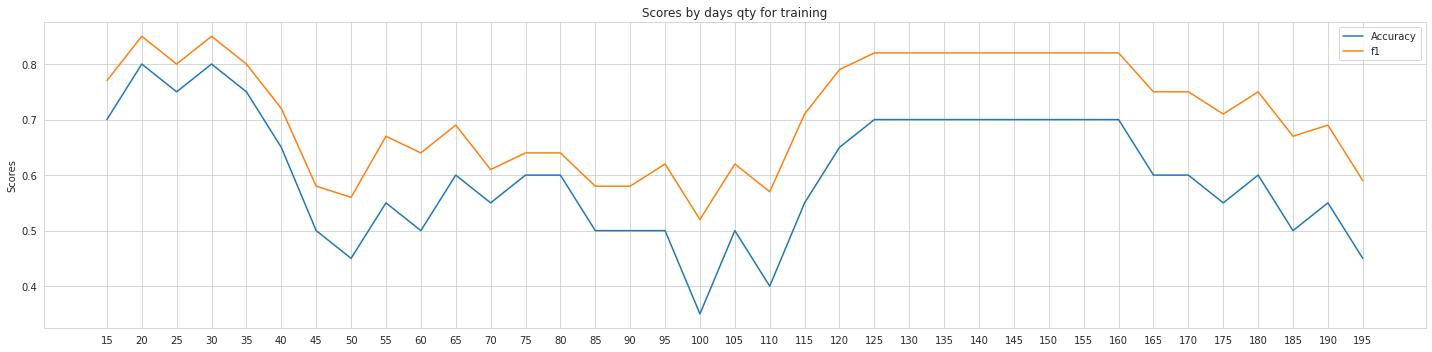

In [207]:
plt.figure(figsize(20,5))

labels = df_metrics.index.tolist()
plt_accuracy_score = round(df_metrics['accuracy_score'], 2)
plt_f1_score = round(df_metrics['f1_score'],2)

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, plt_accuracy_score, width, label='Accuracy')
# rects2 = ax.bar(x + width/2, plt_f1_score, width, label='f1')
rects1 = ax.plot(labels, plt_accuracy_score, label='Accuracy')
rects2 = ax.plot(labels, plt_f1_score, label='f1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by days qty for training')
ax.set_xticks(labels)
# ax.set_xticklabels(labels)
ax.legend()

# ax.bar_label(rects1, padding=1)
# ax.bar_label(rects2, padding=1)

fig.tight_layout()

plt.show();

# Entendendo o uso do aprendizado da Rede Bayesiana

In [ ]:
random.seed(RANDOM_SEED)

X = numpy.random.randint(2, size=(20, 3))
X[:,1] = (X[:,0])
# X[:,2] = (X[:,0]+1)

for algorith in ["exact", "greedy"]:
    model = BayesianNetwork.from_samples(X, algorithm=algorith, reduce_dataset=False, n_jobs=-1)
    plt.figure(figsize=(20, 5))
    model.plot()

In [ ]:
a = networkx.DiGraph()

# a.add_edge(tuple([1, 2]), tuple([0]))
a.add_edge(tuple([0]), tuple([1,2]))

print("Constraint Graph")
plt.figure(figsize=(10, 8))
plot_networkx(a)
plt.show()

In [ ]:
model = BayesianNetwork.from_samples(X, algorithm='exact', reduce_dataset=False
                                     , constraint_graph=a
                                     , n_jobs=-1)

model.bake()
plt.figure(figsize=(20, 5))
model.plot()

In [ ]:
X

In [ ]:
model.predict([[1, None, 1]])